In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.sparse.linalg import eigs
from scipy.integrate import solve_ivp


(0.45301029168136897, 0.1241818769554022)
(0.8734185245691611, 0.1349820876632285)
(1.436961466047747, 0.2603043162259756)


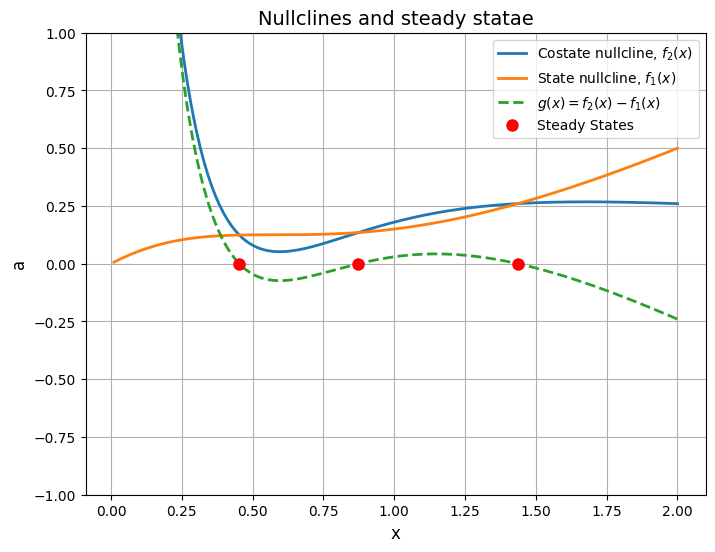

In [118]:
def nullcline_a(x,p,b,c):
     return (p + b - (2*x)/((x**2 + 1)**2)) / (2 * c * x)

def nullcline_x(b,x):
    return b * x - (x**2) / ((x**2 + 1))




b = 0.65
p = 0.03
c = 0.5
x = np.linspace(0.01,2,300)

f2 = nullcline_a(x, p, b, c)
f1 = nullcline_x(b, x)
g_x = f2 - f1

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, f2, label='Costate nullcline, $f_2(x)$', lw=2)
ax.plot(x, f1, label='State nullcline, $f_1(x)$', lw=2)

# Plot the difference g(x)
ax.plot(x, g_x, label='$g(x)=f_2(x)-f_1(x)$', lw=2, ls='--')

# Find and mark zeros of g(x) (steady states)
roots = []
for i in range(len(x)-1):
    if g_x[i] * g_x[i+1] < 0:
        root = fsolve(lambda xi: nullcline_a(xi, p, b, c) - nullcline_x(b, xi), (x[i] + x[i+1]) / 2)
        roots.append(root[0])
roots = np.array(roots)

for root in roots: 
    print((root, nullcline_x(b, root)))

if roots.size > 0:
    ax.plot(roots, np.zeros_like(roots), 'ro', markersize=8, label='Steady States')

# Customize the plot
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('a', fontsize=12)
ax.set_title('Nullclines and steady statae', fontsize=14)
ax.grid(True)
ax.legend(fontsize=10)
ax.set_ylim(-1, 1)

plt.show()


In [64]:
h = .01 
xi = np.linspace(0.01, 10, 1000)

b = 0.65
p = 0.03
c = 0.5

f2 = nullcline_a(xi, p, b, c)
f1 = nullcline_x(b, xi)
g_x = f2 - f1


def intermediate_value(): 
    intervals = [] 
    for i in range(len(xi)-1): 
        if g_x[i] * g_x[i+1] < 0:
            intervals.append(((i+1)/100, (i+2)/100)) # account for starting at .01 instead of zero. 
    return intervals
print(intermediate_value())

[(0.45, 0.46), (0.87, 0.88), (1.43, 1.44)]


Eigenvalues: [ 0.05625567 -0.02625567]
Eigenvectors: [[ 0.          0.08693947]
 [ 1.         -0.9962136 ]]
stable eigenvalue =  -0.026255668301115365
Eigenvalues: [ 0.37404727 -0.34404727]
Eigenvectors: [[ 0.          0.5487629 ]
 [ 1.         -0.83597804]]
stable eigenvalue =  -0.3440472718626341


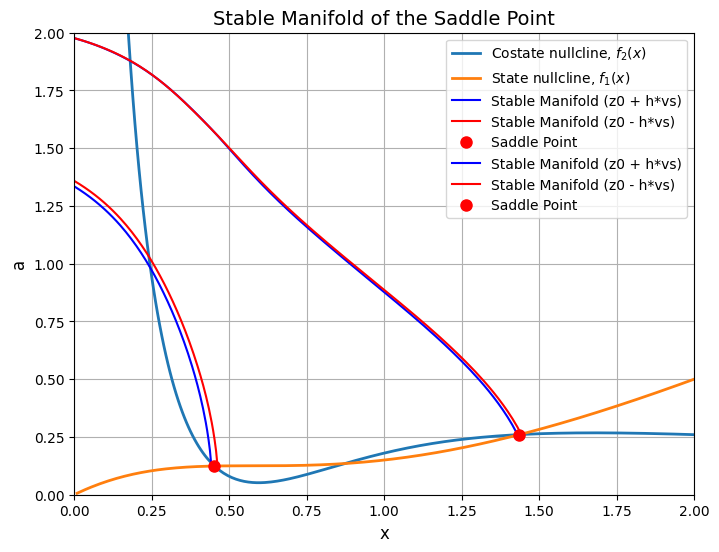

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp



def jacobian(x, l):
    df_dx = -b + (2 * x )/ ((x**2 + 1)**2)
    df_dl = 0
    dg_dx = 2 * c - (((2* l )*(1-3*x**2))/((x**2+1)**3))
    dg_dl = p + b - (2*x)/((x**2 + 1)**2)
    return np.array([[df_dx, df_dl], [dg_dx, dg_dl]])

def state_eq(l, b, x): 
    return -1/l - b*x + (x**2)/(x**2 +1)

def costate_eq(l, b, c, p, x): 
    return (p*l + 2*c*x + l*b - ((2*x*l)/(x**2 + 1)**2))

def system(t, z, b, c, p):
    a, x = z
    return [state_eq(a, b, x), costate_eq(a, b, c, p, x)]


b = 0.65
p = 0.03
c = 0.5

ss1_x = 0.45301029168136897
ss1_a =  0.1241818769554022
ss2_x = 1.436961466047747
ss2_a = 0.2603043162259756


saddles = [(ss1_x, ss1_a) ,(ss2_x, ss2_a)]
# Plot the stable manifold
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, f2, label='Costate nullcline, $f_2(x)$', lw=2)
ax.plot(x, f1, label='State nullcline, $f_1(x)$', lw=2)


for saddle in saddles: 
    J = jacobian(saddle[0], saddle[1])

    # Calculate the eigenvalues and eigenvectors
    values, vectors = np.linalg.eig(J)
    print("Eigenvalues:", values)
    print("Eigenvectors:", vectors)

    # Stable eigenvector (corresponding to the negative eigenvalue)
    stable_idx = np.argmin(np.abs(values))  # Find the negative eigenvalue
    print("stable eigenvalue = ", values[stable_idx])
    stable_eigenvector = vectors[:, stable_idx]
    stable_eigenvector /= np.linalg.norm(stable_eigenvector)  # Normalize to unit length

    # Perturb the saddle point along the stable eigenvector
    h = 0.01
    z0_plus = np.array([saddle[1], saddle[0]]) + h * stable_eigenvector
    z0_minus = np.array([saddle[1], saddle[0]]) - h * stable_eigenvector

    # Integrate backwards in time
    t_span = (10, 0)  # Integrating backwards (from t=10 to t=0)
    sol_plus = solve_ivp(system, t_span, z0_plus, method='RK45', t_eval=np.linspace(10, 0, 1000), args=(b, c, p))
    sol_minus = solve_ivp(system, t_span, z0_minus, method='RK45', t_eval=np.linspace(10, 0, 1000), args=(b, c, p))


    ax.plot(sol_plus.y[1], sol_plus.y[0], 'b-', label='Stable Manifold (z0 + h*vs)')
    ax.plot(sol_minus.y[1], sol_minus.y[0], 'r-', label='Stable Manifold (z0 - h*vs)')
    ax.plot(saddle[0], saddle[1], 'ro', markersize=8, label='Saddle Point')


    
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('a', fontsize=12)
ax.set_title('Stable Manifold of the Saddle Point', fontsize=14)
ax.grid(True)
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.legend(fontsize=10)
plt.show()
